<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/Augmented_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent Workflows

Partiamo da questo _clamoroso_ [articolo](https://www.anthropic.com/research/building-effective-agents) pubblicato da Anthropic.

L'articolo pone enfasi sul provare a utilizzare soluzioni semplici, limitando il ricorso a frameworks.

Sicuramente è vero, ma è altrettanto vero che in alcuni casi l'utilizzo di framework può essere di aiuto.

In questo notebook si mostra una possibile implementazione tramite [LangGraph](https://www.langchain.com/langgraph) del building block **Augmented LLM**, ove al modello viene messo a disposizione una serie di tool.

Il tool in questo caso è l'accesso al web per eseguire ricerche.

Usiamo OpenAI e Tavily (alternativa BraveSearch), per i quali va fornita l'API key.

Iniziamo dal setup

In [45]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community langgraph

In [46]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [47]:
_set_env("TAVILY_API_KEY")

Ora avviamo il modello

In [48]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

Definiamo il modello

In [49]:
import operator
from pydantic import BaseModel, Field
from typing import Annotated
from langgraph.graph import MessagesState

# The state of the graph
class SearchState(MessagesState):
  context: Annotated[list, operator.add]

Definiamo i tool di ricerca

In [50]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [51]:
def search_web(query: str):

    """ Retrieve docs from web search

        Arguments
           query: the query string to use

        Output
           a list of documents to be used in the context
    """

    # Search
    search_docs = tavily_search.invoke(query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return formatted_search_docs

Abbiamo definito quindi il tool per eseguire ricerche sul web, ora completiamo il grafo

In [52]:
tools = [search_web]
llm_with_tools = llm.bind_tools(tools)

In [53]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message

system_prompt = """
You are a helpful assistant.

You are able to search the web to get the right answer to the question provided
by the user.

You should provide the final answer in markdown format and you MUST include the
sources used to answer, showing the url of the web page retrieved by the search tool.

Therefore, the answer should have the following format

# Description

# Sources
-  [source1](link of source1)
-  [source2](link of source1)
"""
sys_msg = SystemMessage(content=system_prompt)

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

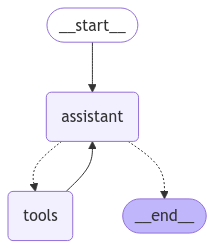

In [54]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Adding memory
memory = MemorySaver()

react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

Ora avviamo il nostro assistente, fornendo un `thread_id` per il checkpointing

In [55]:
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="I want to discuss about the post-rock music genre. Tell me something about it")]

# Run
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to discuss about the post-rock music genre. Tell me something about it
================================== Ai Message ==================================
Tool Calls:
  search_web (call_bX1hXAVAzuVcrzVSsRXFeJ3R)
 Call ID: call_bX1hXAVAzuVcrzVSsRXFeJ3R
  Args:
    query: post-rock music genre
================================= Tool Message =================================
Name: search_web

<Document href="https://www.britannica.com/art/post-rock"/>
Post-rock | Ambient, Experimental, Instrumental | Britannica Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos post-rock Related Questions What is rock music? post-rock Share to social media https://www.britannica.com/art/post-rock Article History Table of Contents Ask the Chatbot a Question rock post-rock, genre of experimental rock music that combined elements

Dato che abbiamo fornito il nostro tool di memoria, possiamo procedere a chiedere informazioni partendo dallo stesso contesto

In [56]:
# Specify an input
messages = [HumanMessage(content="What do you mean with 'emphasis on dynamics and texture'?")]

# Run
messages = react_graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

I want to discuss about the post-rock music genre. Tell me something about it
================================== Ai Message ==================================
Tool Calls:
  search_web (call_bX1hXAVAzuVcrzVSsRXFeJ3R)
 Call ID: call_bX1hXAVAzuVcrzVSsRXFeJ3R
  Args:
    query: post-rock music genre
================================= Tool Message =================================
Name: search_web

<Document href="https://www.britannica.com/art/post-rock"/>
Post-rock | Ambient, Experimental, Instrumental | Britannica Ask the Chatbot Games & Quizzes History & Society Science & Tech Biographies Animals & Nature Geography & Travel Arts & Culture ProCon Money Videos post-rock Related Questions What is rock music? post-rock Share to social media https://www.britannica.com/art/post-rock Article History Table of Contents Ask the Chatbot a Question rock post-rock, genre of experimental rock music that combined elements

La risposta potrebbe essere fornita usando JSON oppure come semplice stringa da passare ai successivi building block.

## LLM Call

Proviamo ora a incapsulare la chiamata al modello in una funzione che può essere richiamata in modo generale da altri contesti

In [59]:
def llm_call(question: str, thread_id: str):
    configurable = {"configurable": {"thread_id": thread_id}}
    messages = [HumanMessage(content=question)]

    react_graph.invoke({"messages": messages}, configurable)
    state = react_graph.get_state(configurable)
    return state[0]['messages'][-1].content
    # return state

Proviamo ora a invocare il nostro augmented LLM

**N.B.** Ricordiamo che lo stato finale è in formato MD, possiamo fare in modo di generare un JSON da passare agli elementi successivi

In [61]:
from IPython.display import Markdown

result = llm_call("Provide me an overview of the new Syrian leadership", "2")

Markdown(result)

# Description

The new leadership in Syria is led by Ahmed al-Sharaa, who has assumed a central role following the overthrow of Bashar al-Assad. Al-Sharaa is focused on fostering unity and holding accountable those who supported the Assad regime's lengthy rule. He has been actively engaging in diplomatic efforts, holding significant discussions with Arab diplomats, including those from Jordan and Qatar, to address Syria's reconstruction and explore future cooperation. This represents a notable shift in Syria's diplomatic relationships, especially with Qatar, which had not engaged at this level for 13 years.

Ahmed al-Sharaa is presenting a more conventional and approachable image, aiming to reassure the West that Syria under his leadership does not pose a threat. This new approach has prompted the U.S. to consider re-evaluating its designation of certain Syrian groups as terrorist organizations, contingent upon their perception of Sharaa's willingness to engage constructively.

# Sources

-  [NBC News](https://www.nbcnews.com/news/world/syria-sharaa-jolan-reassure-no-jihadi-rcna184478)
-  [France24](https://www.france24.com/en/live-news/20241223-jordan-foreign-minister-holds-talks-with-syria-s-new-leader)
-  [PBS News Hour](https://www.pbs.org/newshour/show/syrias-new-leaders-promise-unity-while-also-holding-assad-facilitators-accountable)